#Classificação
Objetivo: A partir de uma base de características de carros, serão gerados modelos de classificação para, a partir de algumas características, indicar se um dado carro possui aceitação ruim ou boa.

Em um primeiro momento, vamos carregar os dados:

In [185]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Mineração de Dados/trabalho5_dados_Luciana.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,preco_compra,custo_manutencao,num_portas,num_pessoas,tam_portamalas,seguranca,aceitacao
0,baixa,baixa,4,4,media,alta,boa
1,media,baixa,5 ou mais,2,media,media,ruim
2,baixa,baixa,3,mais,pequeno,alta,boa
3,media,muito alta,5 ou mais,2,grande,media,ruim
4,media,muito alta,5 ou mais,mais,media,alta,boa


Depois tratá-los:

Número de instâncias antes: 1564
Número de instâncias depois: 1027
{'boa': 297, 'ruim': 730}
Colunas faltando valores: 
[]
Variáveis categóricas: 
['preco_compra', 'custo_manutencao', 'num_portas', 'num_pessoas', 'tam_portamalas', 'seguranca']


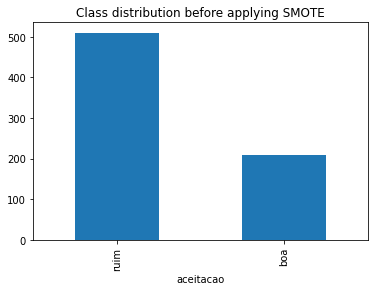

In [186]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# removendo linhas duplicadas
print('Número de instâncias antes: ' + str(len(df)))
df.drop_duplicates(inplace=True)
print('Número de instâncias depois: ' + str(len(df)))

# seleciona o atributo alvo

target = df.aceitacao
aceitacao_predictors = df.drop(['aceitacao'], axis=1)

# vamos tratar classes desbalanceadas para não haver overfitting para uma certa classe 
classes, counting = np.unique(target, return_counts=True)
print(dict(zip(classes, counting)))

# dividir em conjunto de treinamento e teste

X_train, X_test, y_train, y_test = train_test_split(aceitacao_predictors, target, train_size=0.7, test_size=0.3, stratify=target, random_state=0)

pd.Series(y_train).value_counts().plot(kind='bar', title='Class distribution before applying SMOTE', xlabel='aceitacao')

# verifico se há valores nulos

cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

print("Colunas faltando valores: ")
print(cols_with_missing)

# tratar as variáveis categóricas
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Variáveis categóricas: ")
print(object_cols)

ordinal_encoder = OrdinalEncoder()
label_encoder = LabelEncoder()

# cópia para não mudar dados originais
label_X_train = X_train.copy()
label_X_test = X_test.copy()
label_y_train = y_train.copy()
label_y_test = y_test.copy()

label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_test[object_cols] = ordinal_encoder.transform(X_test[object_cols])
label_y_train = label_encoder.fit_transform(y_train)
label_y_test = label_encoder.transform(y_test)


{0: 510, 1: 510}


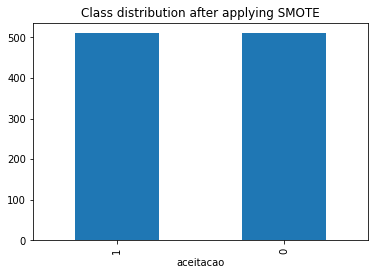

In [187]:
# tratar dados desbalanceados entre as classes
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(label_X_train, label_y_train)

pd.Series(y_resampled).value_counts().plot(kind='bar', title='Class distribution after applying SMOTE', xlabel='aceitacao')

classes, counting = np.unique(y_resampled, return_counts=True )
print(dict(zip(classes, counting)))

In [188]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(X_resampled)
x_test = scaler.transform(label_X_test)

Com os dados tratados, vamos aos modelos:

## Regressão Logística


In [189]:
from sklearn.linear_model import LogisticRegression

model_LR = LogisticRegression()
model_LR.fit(x_train, y_resampled)
predicted_y = model_LR.predict(x_test)


Vamos analisar a matriz de confusão:

In [190]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(label_y_test, predicted_y).ravel()
print('True negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn, '\nTrue positives: ', tp)

True negatives:  48 
False positives:  41 
False negatives:  96 
True positives:  124


Mais algumas outras métricas:

In [191]:
from sklearn.metrics import classification_report

print(classification_report(label_y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.33      0.54      0.41        89
           1       0.75      0.56      0.64       220

    accuracy                           0.56       309
   macro avg       0.54      0.55      0.53       309
weighted avg       0.63      0.56      0.58       309



Vamos analisar a importância das features na predição do modelo LR:

Feature: 0, Score: 0.11732
Feature: 1, Score: 0.22021
Feature: 2, Score: -0.29947
Feature: 3, Score: -0.02022
Feature: 4, Score: 0.37244
Feature: 5, Score: 0.32017


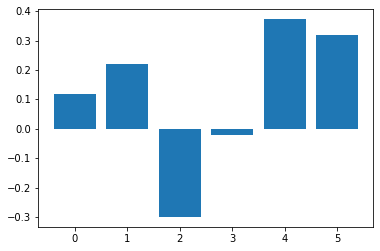

In [192]:
from matplotlib import pyplot

# get importance
importance = model_LR.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Foi observado que segurança e tamanho do porta-malas possuem uma importância maior quando a aceitação é ruim, enquanto número de portas possui uma importância maior quando a aceitação é boa.

## Árvores de decisão

In [193]:
from sklearn.tree import DecisionTreeClassifier

model_DT = DecisionTreeClassifier()
model_DT.fit(x_train, y_resampled)
predicted_y_DT = model_DT.predict(x_test)

Vamos analisar a matriz de confusão:

In [194]:
tn_dt, fp_dt, fn_dt, tp_dt = confusion_matrix(label_y_test, predicted_y_DT).ravel()
print('True negatives: ', tn_dt, '\nFalse positives: ', fp_dt, '\nFalse negatives: ', fn_dt, '\nTrue positives: ', tp_dt)

True negatives:  86 
False positives:  3 
False negatives:  3 
True positives:  217


Algumas outras métricas:

In [195]:
print(classification_report(label_y_test, predicted_y_DT))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        89
           1       0.99      0.99      0.99       220

    accuracy                           0.98       309
   macro avg       0.98      0.98      0.98       309
weighted avg       0.98      0.98      0.98       309



Tomada de decisão:

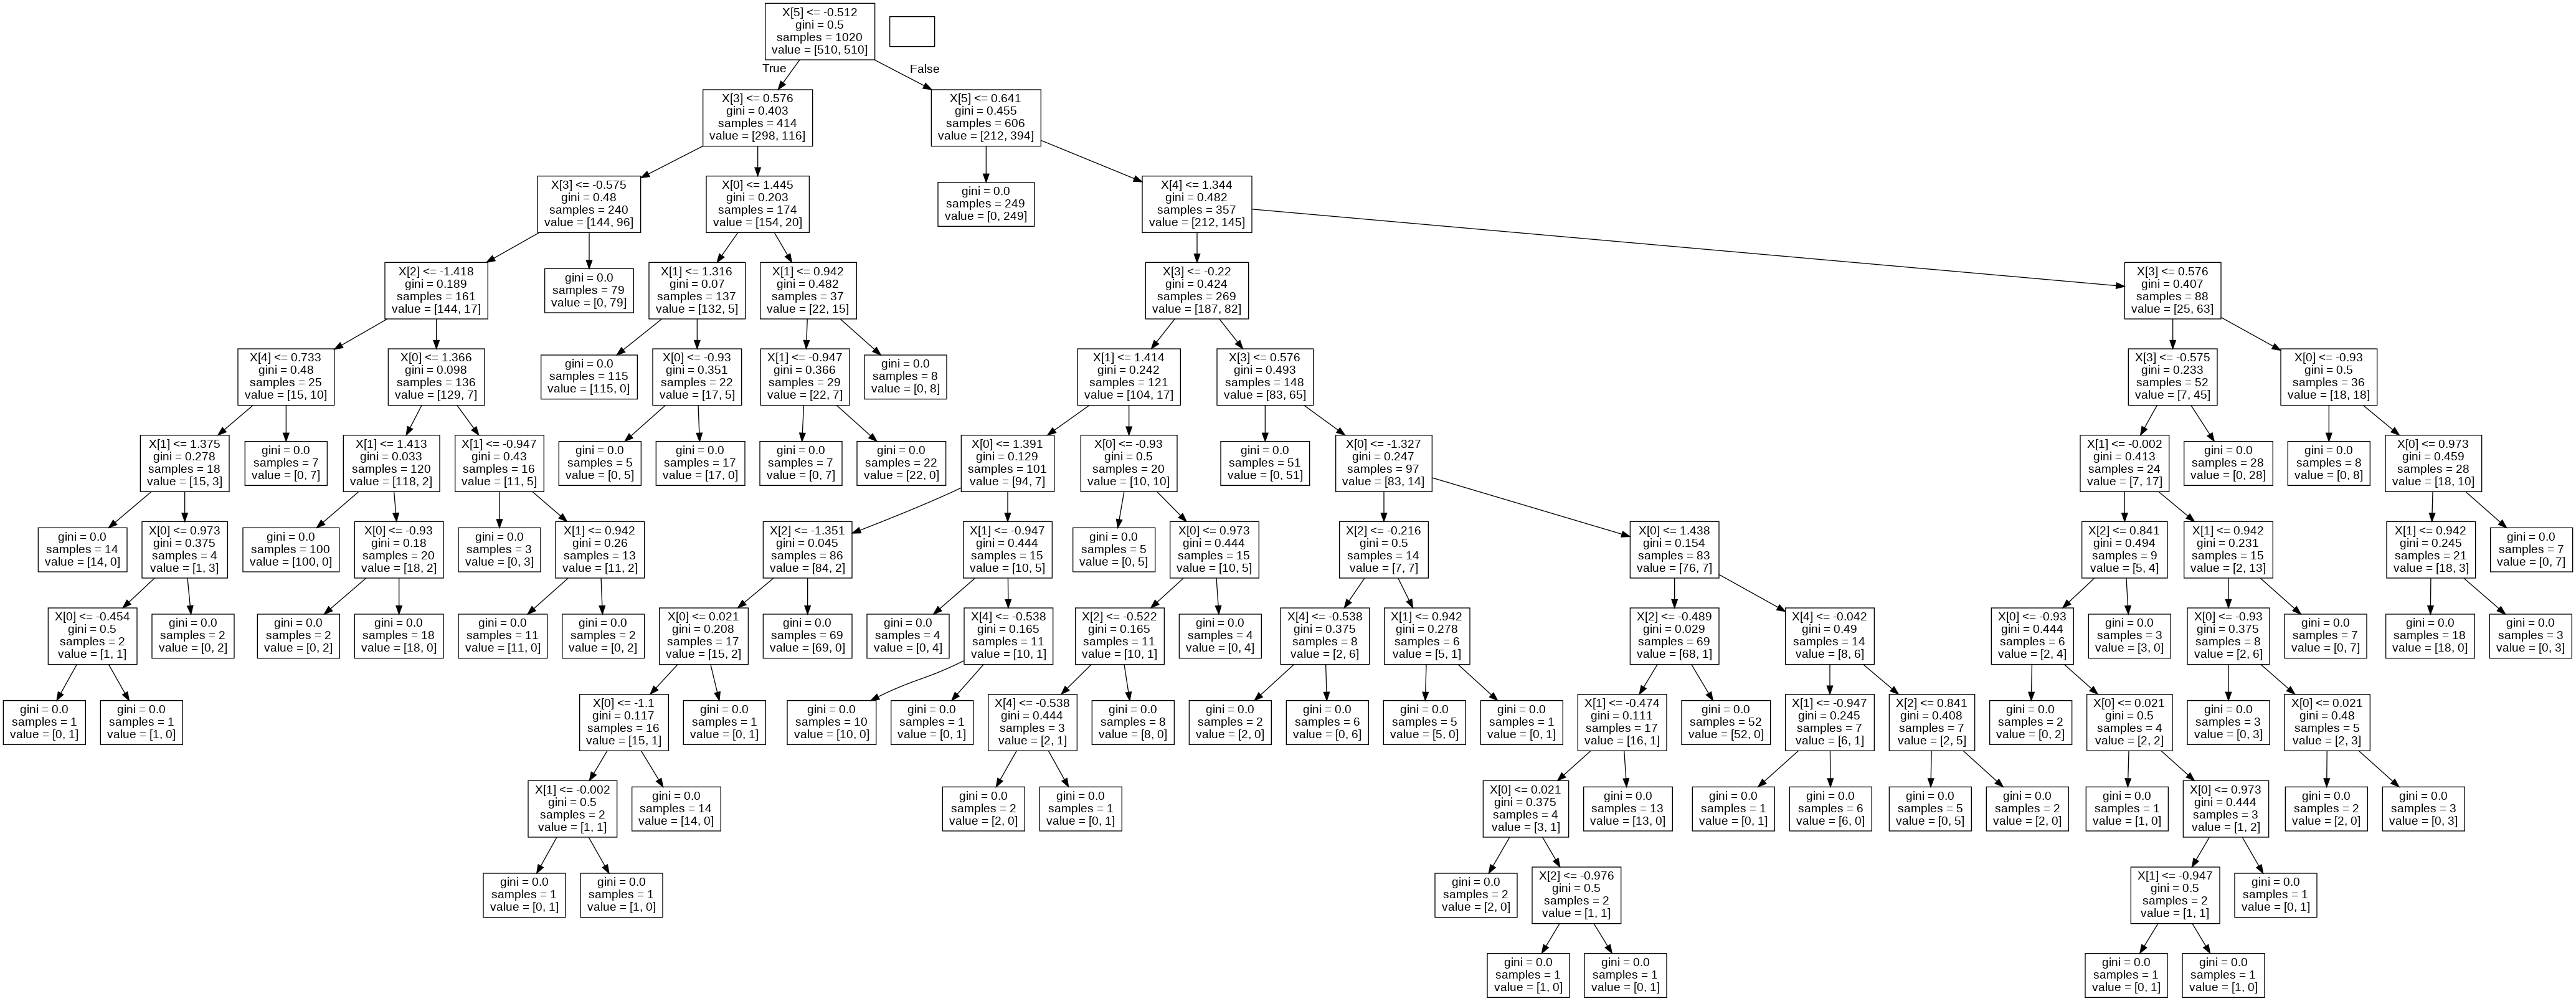

In [196]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(model_DT, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Importância de algumas features:

Feature: 0, Score: 0.12265
Feature: 1, Score: 0.10760
Feature: 2, Score: 0.02755
Feature: 3, Score: 0.33311
Feature: 4, Score: 0.07421
Feature: 5, Score: 0.33489


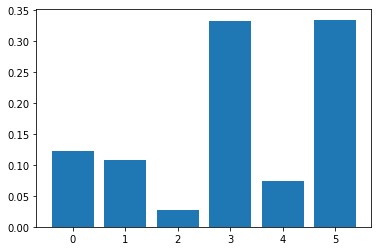

In [197]:
# get importance
importance_DT = model_DT.feature_importances_
# summarize feature importance
for i,v in enumerate(importance_DT):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance_DT))], importance_DT)
pyplot.show()

Número de pessoas que cabem no carro e segurança foram decisivos na predição para este classificador.

## Vamos, por fim, fazer uma análise estatística de ambos os modelos:

In [198]:
from sklearn.metrics import accuracy_score
n_tests = 30

DT_model = DecisionTreeClassifier()
LR_model = LogisticRegression()

accuracies_DT = []
accuracies_LR = []

for i in range(n_tests):
  X_train, X_test, y_train, y_test = train_test_split(aceitacao_predictors, target, train_size=0.7, test_size=0.3, stratify=target, random_state=i)
  label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
  label_X_test[object_cols] = ordinal_encoder.transform(X_test[object_cols])
  label_y_train = label_encoder.fit_transform(y_train)
  label_y_test = label_encoder.transform(y_test)
  X_resampled, y_resampled = smote.fit_resample(label_X_train, label_y_train)
  x_train = scaler.fit_transform(X_resampled)
  x_test = scaler.transform(label_X_test)
  # treinando modelo DT
  DT_model.fit(x_train, y_resampled)
  y_pred_DT = DT_model.predict(x_test)
  accuracy_DT = accuracy_score(label_y_test, y_pred_DT)
  accuracies_DT.append(accuracy_DT)
  # treinando modelo LR
  LR_model.fit(x_train, y_resampled)
  y_pred_LR = LR_model.predict(x_test)
  accuracy_LR = accuracy_score(label_y_test, y_pred_LR)
  accuracies_LR.append(accuracy_LR)

print("Média das acurácias do Decision Tree: %f"%np.mean(accuracies_DT))
print("Desvio padrão das acurácias do Decision Tree: %f"%np.std(accuracies_DT))

print("Média das acurácias do Logistic Regression: %f"%np.mean(accuracies_LR))
print("Desvio padrão das acurácias do Logistic Regression: %f"%np.std(accuracies_LR))

Média das acurácias do Decision Tree: 0.966559
Desvio padrão das acurácias do Decision Tree: 0.013789
Média das acurácias do Logistic Regression: 0.589752
Desvio padrão das acurácias do Logistic Regression: 0.022649


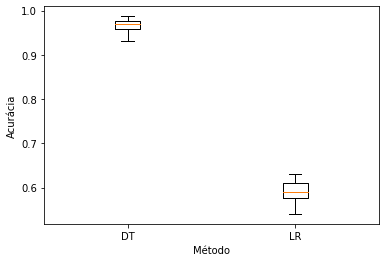

In [199]:
accuracies = [accuracies_DT, accuracies_LR]
fig, ax = plt.subplots()
ax.boxplot(accuracies, labels=["DT", "LR"])
plt.xlabel("Método")
plt.ylabel("Acurácia")
plt.show()

O modelo com melhor desempenho foi o Decision Tree, e as features principais na predição foram número de pessoas e segurança.